# Active site analysis

# Imports

In [1]:
import MDAnalysis as mda
import MDAnalysis.analysis.distances
# import BioSimSpace as bss
import numpy as np
import nglview as nv
import os
import matplotlib.pyplot as plt


# Functions

In [2]:
def get_universe(file_path: str) -> tuple:
    """
    get PARM7, DCD files and return universe
    """
    topology = file_path + "somd.prm7"
    trajectory = file_path + "traj000000002.dcd"
    if not os.path.isfile(trajectory):
        trajectory = file_path + "traj000000001.dcd"
    return mda.Universe(topology, trajectory, topology_format="PARM7")


def get_coumarin_ring(ligand_group: mda.AtomGroup) -> mda.AtomGroup:
    """
    return atom group containing coumarin ring atoms
    """
    coumarin_ring_selection = "name C02 C03 C04 O C06 C08 C09 C15 C C17"
    return ligand_group.select_atoms(coumarin_ring_selection)


def get_indole_rings(protein_group: mda.AtomGroup) -> mda.AtomGroup:
    """
    find tryptophan 82 and return its rings as an atom group
    """
    tryptophan = protein_group.select_atoms("resname TRP and resid 82")
    indole_ring_selection = "name CG CD1 NE1 CE2 CZ2 CH2 CZ3 CE3 CD2"
    return tryptophan.select_atoms(indole_ring_selection)


def get_pyrrole_ring(indole_ring_group: mda.AtomGroup) -> mda.AtomGroup:
    pyrrole_ring_selections = "name CD1 CG CD2 CE2 NE1"
    return indole_ring_group.select_atoms(pyrrole_ring_selections)


def get_lactone_ring(coumarin_ring_group: mda.AtomGroup) -> mda.AtomGroup:
    """
    return lactone part of coumarin ring
    """
    lactone_ring_selections = "name C04 O C06 C08 C09 C15"
    return coumarin_ring_group.select_atoms(lactone_ring_selections)


def get_benzene_ring(reference_group: mda.AtomGroup, selection: str) -> mda.AtomGroup:
    """
    take a bicyclic atom group and select its benzene ring
    """
    return reference_group.select_atoms(selection)


In [6]:
file_path = "../outputs/SOMD/lig_h_1~lig_h_2/bound/lambda_1.0000/"
u = get_universe(file_path)

view = nv.show_mdanalysis(u)
# view.add_representation("ball+stick", selection="protein")
view

NGLWidget(max_frame=499)

In [13]:
file_path = "../outputs/SOMD/lig_h_1~lig_h_2/bound/lambda_1.0000/"
u = get_universe(file_path)

protein = u.select_atoms("protein")
ligand = u.select_atoms("resname LIG")

view = nv.NGLWidget()
view.add_component(protein)
view.add_component(ligand)
view.add_trajectory(file_path + "traj000000001.dcd")
view

AttributeError: 'str' object has no attribute '__module__'

# Get all data

In [3]:
ligand_indices_all = np.arange(2, 17, 1)
ligand_indices = np.delete(ligand_indices_all, [10, 12, 13])
ligand_data = []
tryptophan_data = []
trajectories = []
bonding_data = []
for i in ligand_indices:
    path = f"../outputs/SOMD/lig_h_1~lig_h_{i}/bound/lambda_1.0000/"
    print(path)
    universe = get_universe(path)
    trajectory = universe.trajectory
    trajectories.append(trajectory)
    times = [frame.time for frame in trajectory]

    protein = universe.select_atoms("protein")
    indole_ring = get_indole_rings(protein)
    pyrrole_ring = get_pyrrole_ring(indole_ring)
    indole_benzene_selection = "name CH2 CZ2 CE2 CD2 CE3 CZ3"
    indole_benzene = get_benzene_ring(indole_ring, indole_benzene_selection)
    tryptophan_data.append((times, indole_ring, pyrrole_ring, indole_benzene))
    
    ligand = universe.select_atoms("resname LIG")
    coumarin_ring = get_coumarin_ring(ligand)
    lactone_ring = get_lactone_ring(coumarin_ring)
    coumarin_benzene_selection = "name C02 C03 C04 C15 C C17"
    coumarin_benzene = get_benzene_ring(coumarin_ring, coumarin_benzene_selection)
    ligand_data.append((times, coumarin_ring, lactone_ring, coumarin_benzene))

    bonding_data.append((times, protein, ligand))

    

../outputs/SOMD/lig_h_1~lig_h_2/bound/lambda_1.0000/
../outputs/SOMD/lig_h_1~lig_h_3/bound/lambda_1.0000/
../outputs/SOMD/lig_h_1~lig_h_4/bound/lambda_1.0000/
../outputs/SOMD/lig_h_1~lig_h_5/bound/lambda_1.0000/
../outputs/SOMD/lig_h_1~lig_h_6/bound/lambda_1.0000/
../outputs/SOMD/lig_h_1~lig_h_7/bound/lambda_1.0000/
../outputs/SOMD/lig_h_1~lig_h_8/bound/lambda_1.0000/
../outputs/SOMD/lig_h_1~lig_h_9/bound/lambda_1.0000/
../outputs/SOMD/lig_h_1~lig_h_10/bound/lambda_1.0000/
../outputs/SOMD/lig_h_1~lig_h_11/bound/lambda_1.0000/
../outputs/SOMD/lig_h_1~lig_h_13/bound/lambda_1.0000/
../outputs/SOMD/lig_h_1~lig_h_16/bound/lambda_1.0000/


# C7 distance to L144

In [32]:
distances_1 = []
distances_2 = []
for i in range(len(trajectories)):
    delta_carbons_distance_1 = []
    delta_carbons_distance_2 = []
    for frame in trajectories[i]: 
        leucine = bonding_data[i][1].select_atoms("resid 144")
        ligand = bonding_data[i][2]
        delta_carbon_1 = leucine.select_atoms("name CD1").center_of_mass()
        delta_carbon_2 = leucine.select_atoms("name CD2").center_of_mass()
        ligand_c7 = ligand.select_atoms("name C02").center_of_mass()
        distance_1 = mda.analysis.distances.distance_array(ligand_c7, delta_carbon_1)
        distance_2 = mda.analysis.distances.distance_array(ligand_c7, delta_carbon_2)
        delta_carbons_distance_1.append((frame.time, distance_1[0][0]))
        delta_carbons_distance_2.append((frame.time, distance_2[0][0]))
    delta_carbons_distance_1 = np.asarray(delta_carbons_distance_1)
    delta_carbons_distance_2 = np.asarray(delta_carbons_distance_2)

    mean_distance_1 = np.mean(delta_carbons_distance_1[:,1])
    std_distance_1 = np.std(delta_carbons_distance_1[:,1])
    mean_distance_2 = np.mean(delta_carbons_distance_2[:,1])
    std_distance_2 = np.std(delta_carbons_distance_2[:,1])

    distances_1.append((delta_carbons_distance_1[:,0], delta_carbons_distance_1[:,1], mean_distance_1, std_distance_1))
    distances_2.append((delta_carbons_distance_2[:,0], delta_carbons_distance_2[:,1], mean_distance_2, std_distance_2))
distances_1 = np.asarray(distances_1)
distances_2 = np.asarray(distances_2)





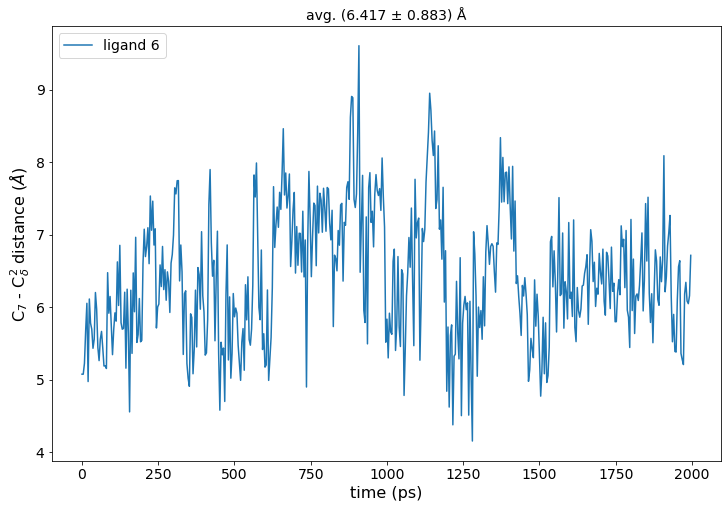

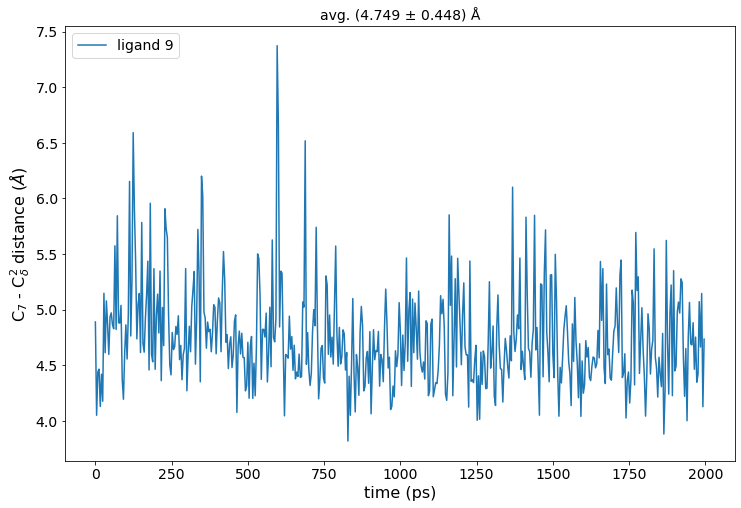

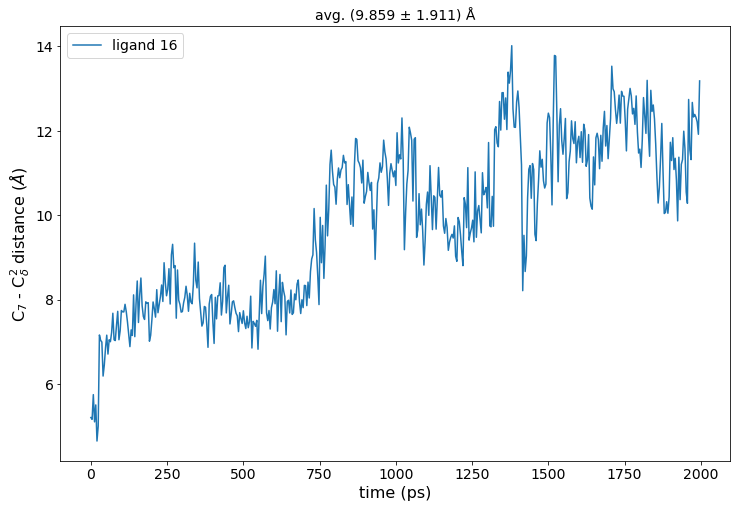

In [40]:
chosen_indices = [4, 7, -1]
for i in chosen_indices:
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 8)
    ax.plot(distances_2[i][0][:], distances_2[i][1][:], label=f"ligand {ligand_indices[i]}")
    ax.set_xlabel("time (ps)")
    ax.set_ylabel(r"C$_7$ - C$_{\delta}^2$ distance ($\AA$)")

    ax.set_title(f"avg. ({distances_2[i][2]:.3f} \u00B1 {distances_2[i][3]:.3f}) \u212B")
    ax.legend(loc="upper left")
    fig.savefig(f"../../plots/active_site_distances/c7_leu_distance_{ligand_indices[i]}.pdf")
    plt.show()
    
    
    

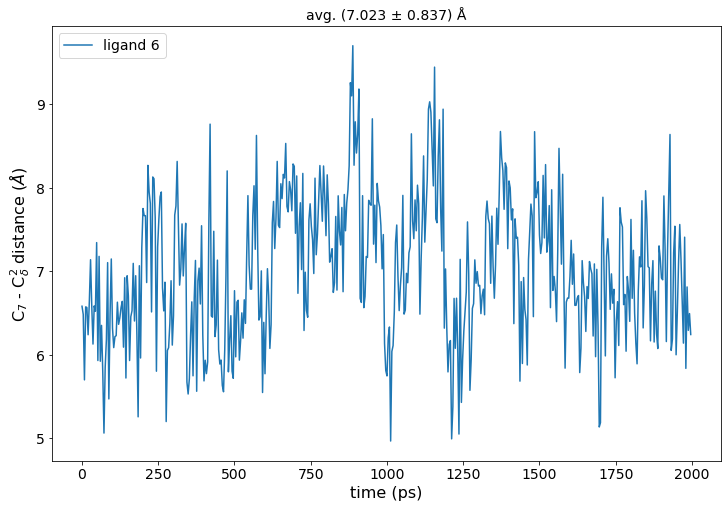

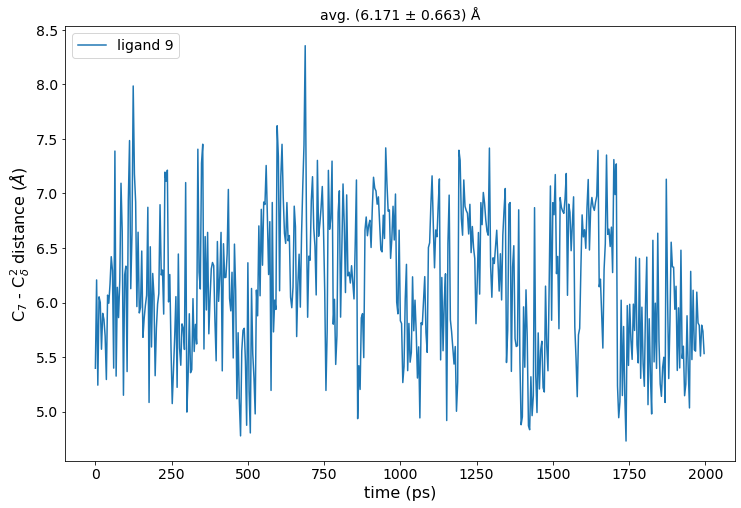

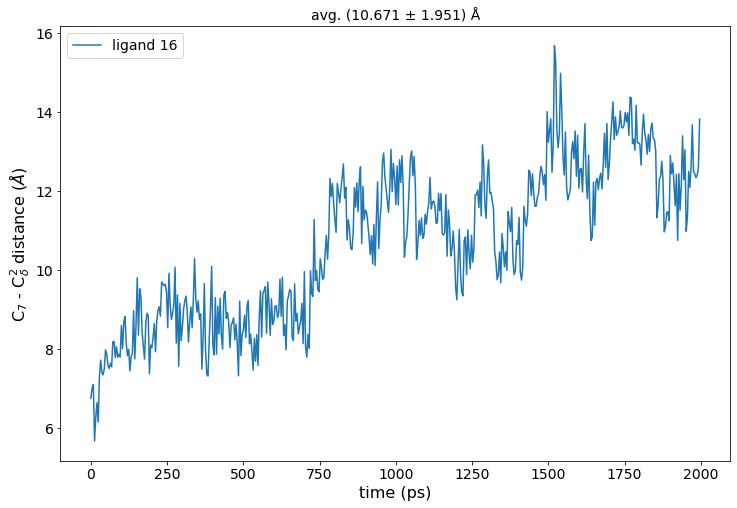

In [41]:
chosen_indices = [4, 7, -1]
for i in chosen_indices:
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 8)
    ax.plot(distances_1[i][0][:], distances_1[i][1][:], label=f"ligand {ligand_indices[i]}")
    ax.set_xlabel("time (ps)")
    ax.set_ylabel(r"C$_7$ - C$_{\delta}^2$ distance ($\AA$)")

    ax.set_title(f"avg. ({distances_1[i][2]:.3f} \u00B1 {distances_1[i][3]:.3f}) \u212B")
    ax.legend(loc="upper left")
    # fig.savefig(f"../../plots/active_site_distances/c7_leu_distance_{ligand_indices[i]}.pdf")
    plt.show()

In [9]:
nv.show_mdanalysis(leucine)

NGLWidget(max_frame=499)

# Centroid distances between coumarin and indole

In [42]:
distances = []
for i in range(len(trajectories)):
    coumarin_indole_distances = []
    coumarin_centroids = []
    indole_centroids = []
    for frame in trajectories[i]:
        times = ligand_data[i][0]
        coumarin_ring = ligand_data[i][1]
        lactone_ring = ligand_data[i][2]
        coumarin_benzene = ligand_data[i][3]
        indole_ring = tryptophan_data[i][1]
        pyrrole_ring = tryptophan_data[i][2]
        indole_benzene = tryptophan_data[i][2]
        coumarin_centroid = coumarin_ring.centroid()
        indole_centroid = indole_ring.centroid()
        coumarin_indole_distance = mda.analysis.distances.distance_array(coumarin_centroid, indole_centroid)
        coumarin_indole_distances.append((frame.time, coumarin_indole_distance[0][0]))
        coumarin_centroids.append((frame.time, coumarin_centroid[0]))
        indole_centroids.append((frame.time, indole_centroid[0]))
    coumarin_indole_distances = np.asarray(coumarin_indole_distances)
    coumarin_centroids = np.asarray(coumarin_centroids)
    indole_centroids = np.asarray(indole_centroids)

    mean_distance = np.mean(coumarin_indole_distances[:,1])
    std_distance = np.std(coumarin_indole_distances[:,1])

    distances.append((coumarin_indole_distances[:,0], coumarin_indole_distances[:,1], mean_distance, std_distance))

distances = np.asarray(distances)
    


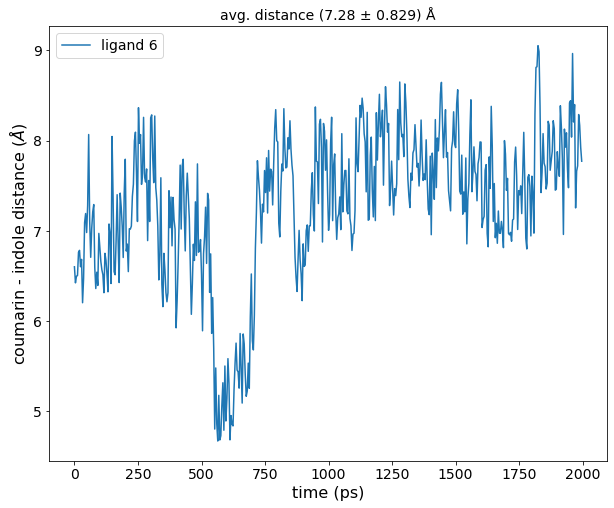

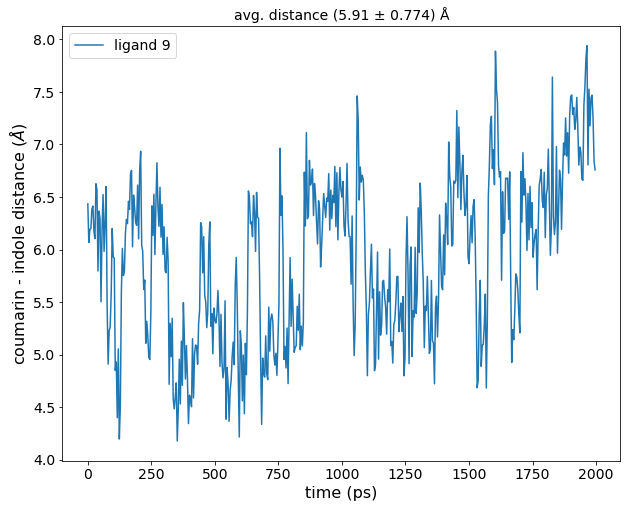

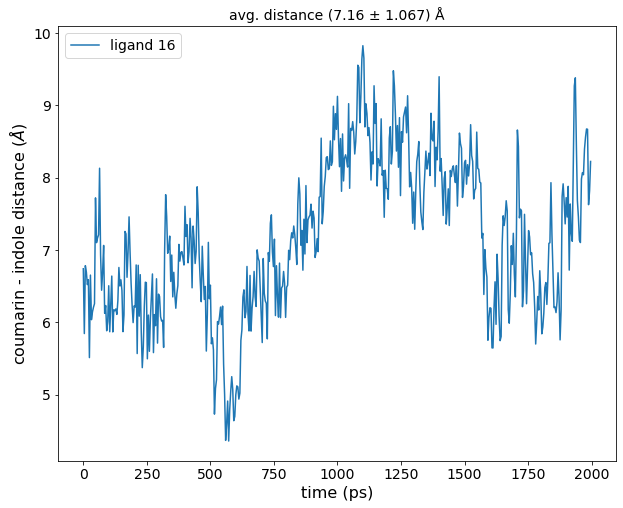

In [45]:
chosen_indices = [4, 7, -1]
for i in chosen_indices:
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 8)
    ax.plot(distances[i][0][:], distances[i][1][:], label=f"ligand {ligand_indices[i]}")
    ax.set_xlabel("time (ps)")
    ax.set_ylabel(r"coumarin - indole distance ($\AA$)")
    ax.set_title(f"avg. distance ({distances[i][2]:.3} \u00B1 {distances[i][3]:.3f}) \u212B")
    ax.legend(loc="upper left")
    fig.savefig(f"../../plots/active_site_distances/coumarin_inodole_distance_{ligand_indices[i]}.pdf")
    plt.show()
    

# Ring centroid distances 

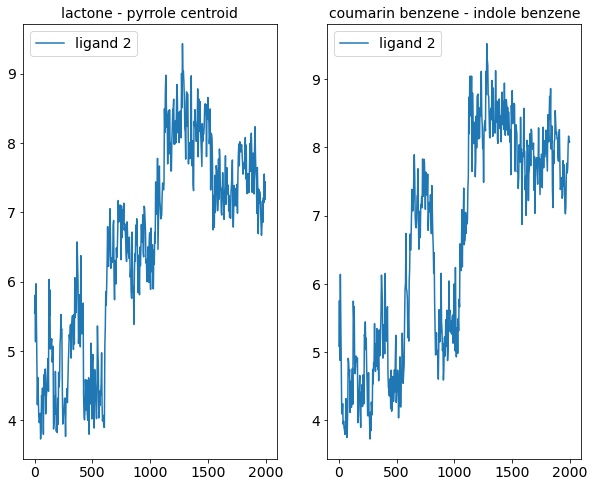

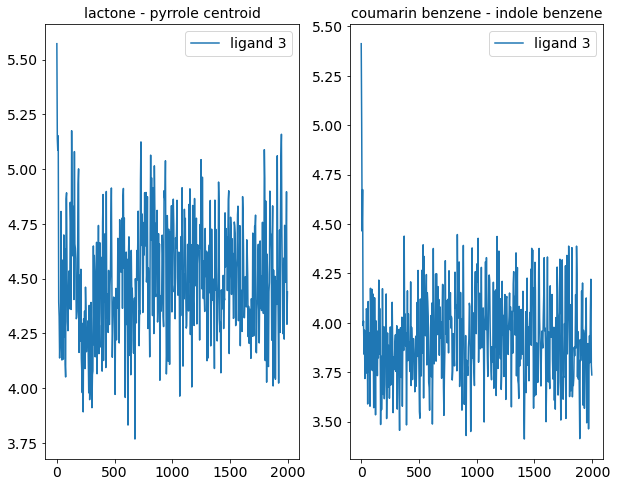

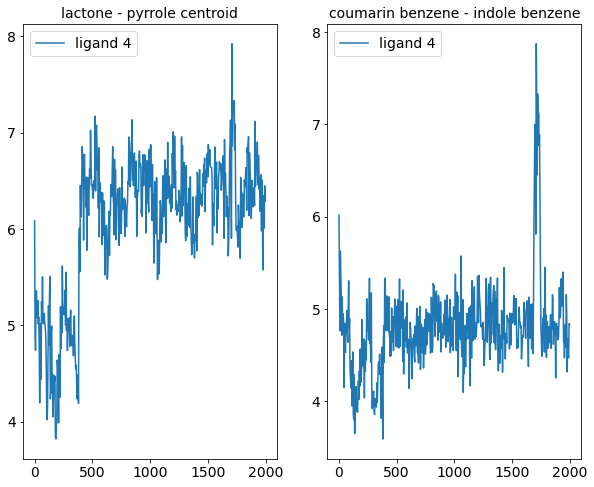

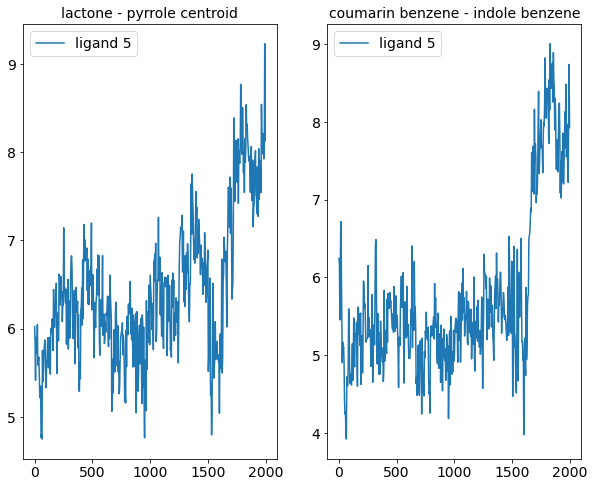

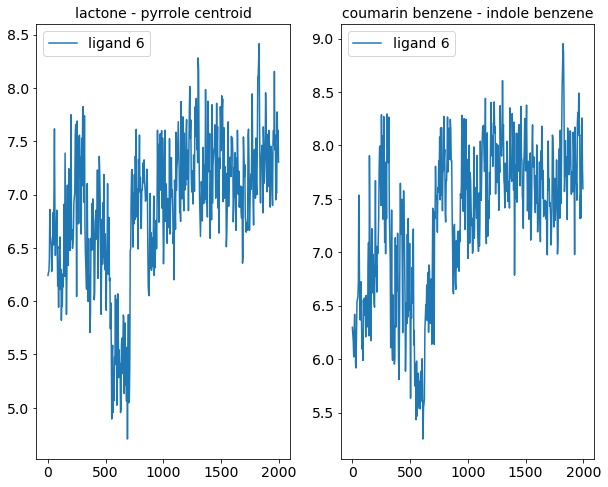

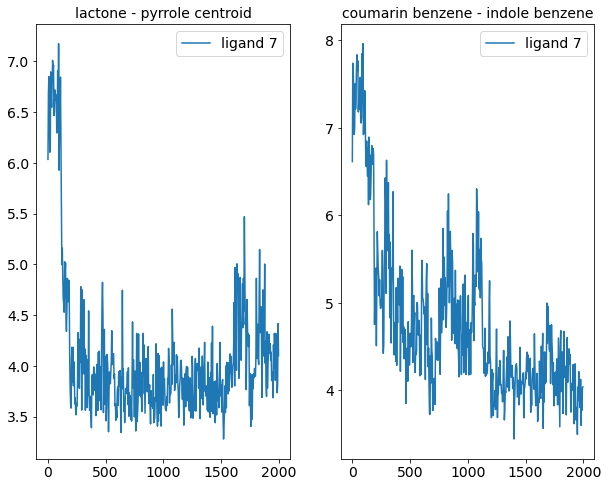

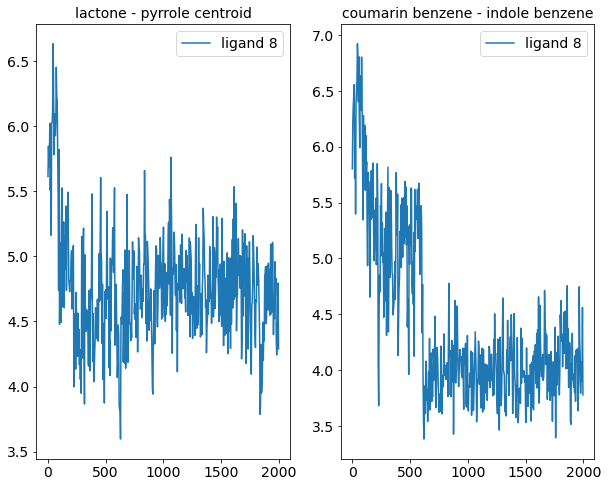

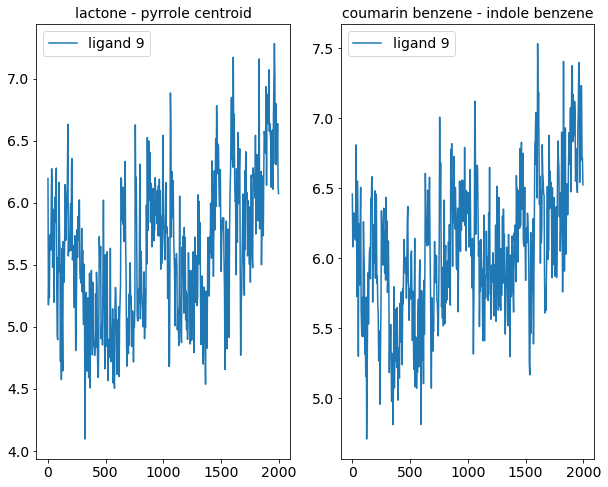

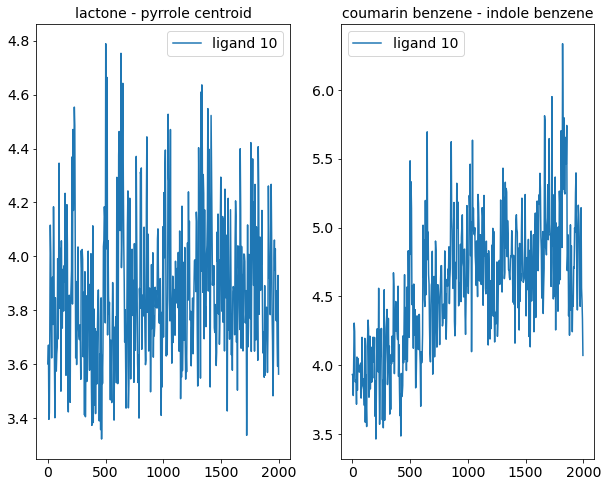

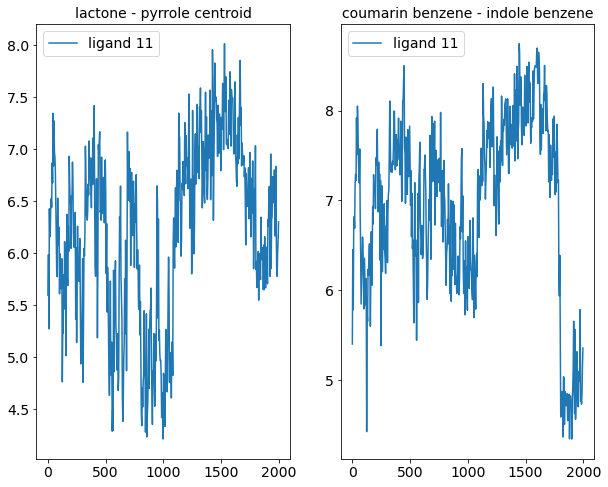

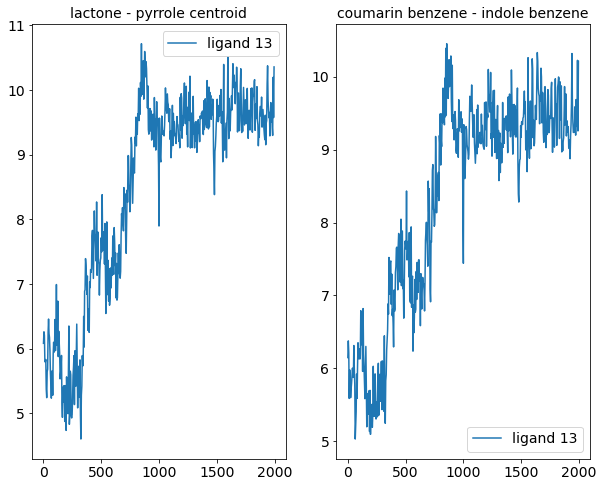

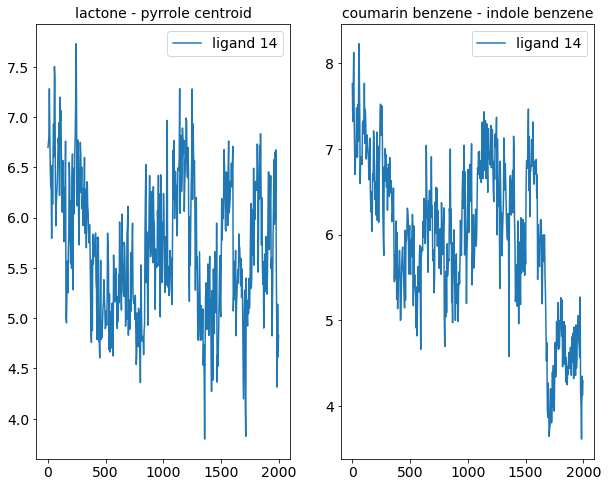

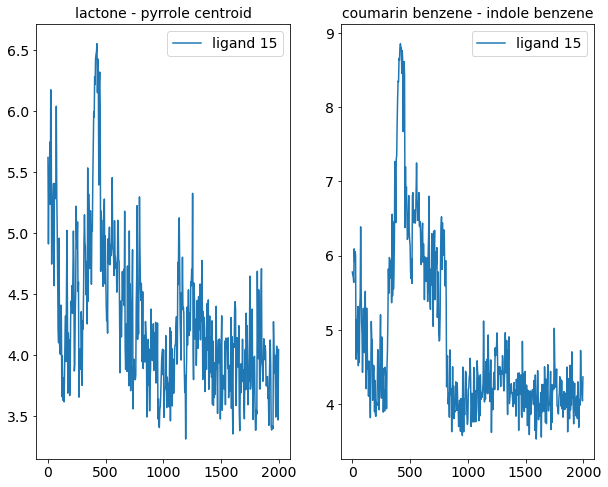

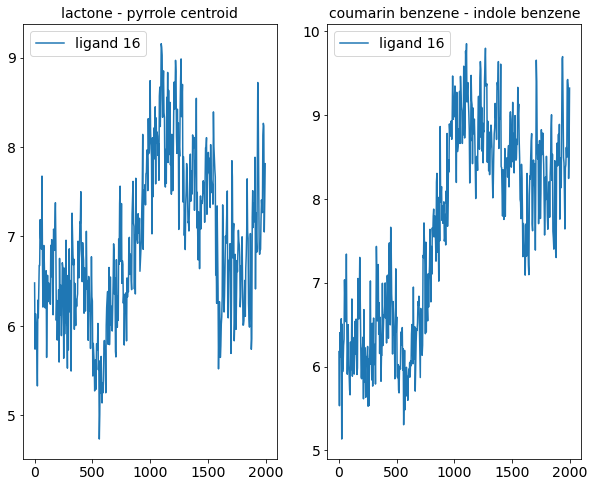

In [56]:
for i in range(len(trajectories)):
    lactone_pyrrole_distances = []
    bb_distances = []
    for frame in trajectories[i]:
        times = ligand_data[i][0]
        lactone_ring = ligand_data[i][2]
        coumarin_benzene = ligand_data[i][3]
        pyrrole_ring = tryptophan_data[i][2]
        indole_benzene = tryptophan_data[i][2]

        lactone_centroid = lactone_ring.centroid()
        pyrrole_centroid = pyrrole_ring.centroid()
        coumarin_b_centroid = coumarin_benzene.centroid()
        indole_b_centroid = indole_benzene.centroid()
        
        lactone_pyrrole_distance = mda.analysis.distances.distance_array(lactone_centroid, pyrrole_centroid)
        lactone_pyrrole_distances.append((frame.time, lactone_pyrrole_distance[0][0]))

        bb_distance = mda.analysis.distances.distance_array(coumarin_b_centroid, indole_b_centroid)
        bb_distances.append((frame.time, bb_distance[0][0]))
        
    lactone_pyrrole_distances = np.asarray(lactone_pyrrole_distances)
    bb_distances = np.asarray(bb_distances)

    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(10, 8)
    ax[0].plot(lactone_pyrrole_distances[:,0], lactone_pyrrole_distances[:,1], label=f"ligand {ligand_indices[i]}")
    ax[0].set_title("lactone - pyrrole centroid")
    ax[1].plot(bb_distances[:,0], bb_distances[:,1], label=f"ligand {ligand_indices[i]}")
    ax[1].set_title("coumarin benzene - indole benzene")
    # ax[2].plot(indole_centroids[:,0], indole_centroids[:,1], label=f"ligand {ligand_indices[i]}")
    # ax[2].set_title("indole centroid coordinates")
    ax[0].legend()
    ax[1].legend()
    # ax[2].legend()
    plt.show()
    


# Carbonyl oxygen distance from HIS274 & ARG220

### Kind of doesn't matter right now because 14 and 15 are wrong...

[38.57566071 44.24780273 32.54027939]
[38.31439972 43.91638184 32.64008331]
[38.59563828 44.46504593 32.9228363 ]
[38.27203751 43.88930511 32.71260452]
[38.30804443 44.2943573  33.1891861 ]
[38.02484131 43.29865646 32.98839951]
[38.58452988 44.36419678 32.77005005]
[38.4290657  44.31295395 32.83660126]
[38.38253784 43.54146576 32.66377258]
[37.775383   42.98684692 32.51508331]
[37.92011642 43.33342743 32.44590378]
[38.24763107 43.58757782 32.71843719]
[38.44179153 44.3216629  32.60645294]
[38.07912827 43.36313629 32.27521133]
[38.14015961 43.79272079 32.66987991]
[38.08403015 43.48229218 32.13928223]
[37.90583801 43.90032196 32.02624512]
[38.09390259 43.74543762 32.22311783]
[38.46491241 43.82527542 31.795578  ]
[38.12815094 43.61607361 32.44592667]
[38.45763016 43.56638718 32.21638107]
[38.13269806 43.38581085 32.22603607]
[38.26029205 43.46519089 32.11048889]
[38.21234512 43.8727417  32.10311508]
[37.79636765 43.40078354 32.2481041 ]
[38.14463806 43.64044189 32.01320648]
[38.14046097

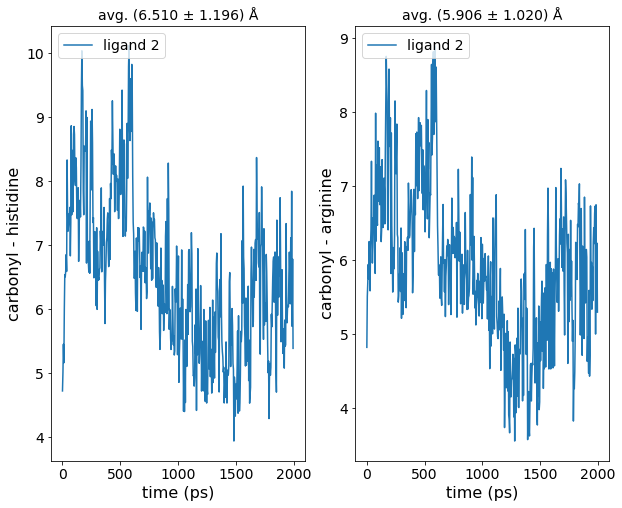

[38.13341904 44.31330109 32.38796234]
[38.42455673 44.13339615 32.65197754]
[38.58240509 44.04981995 32.39701843]
[38.59914398 44.2810173  32.36520386]
[38.78897858 43.88071442 32.70224762]
[38.4902916  44.52733994 32.66436768]
[38.60028839 43.50021744 32.55244827]
[37.87363815 43.40558243 32.43891144]
[38.4025116  43.73828125 32.74687576]
[38.01016235 43.84306335 32.6263504 ]
[38.08394623 44.03308105 32.71242142]
[38.13145828 44.19879532 32.36419296]
[38.50314331 44.23677826 32.67941284]
[38.58097839 43.81443405 32.28809738]
[38.32738495 43.84549713 32.33877945]
[38.44765854 43.79345703 32.35638809]
[38.78514862 44.14151382 32.50212097]
[38.27451324 43.50583267 32.32299042]
[38.37804794 43.36216736 32.04442978]
[38.35957336 43.34278107 32.30048752]
[38.4379158  43.91065598 32.49461746]
[38.23302841 43.60489655 32.38687134]
[38.27175903 43.80379486 32.27928543]
[38.8646698  44.01379776 32.96105576]
[38.48403549 43.82271576 32.47309113]
[38.81237411 43.42301559 32.7249794 ]
[38.59107971

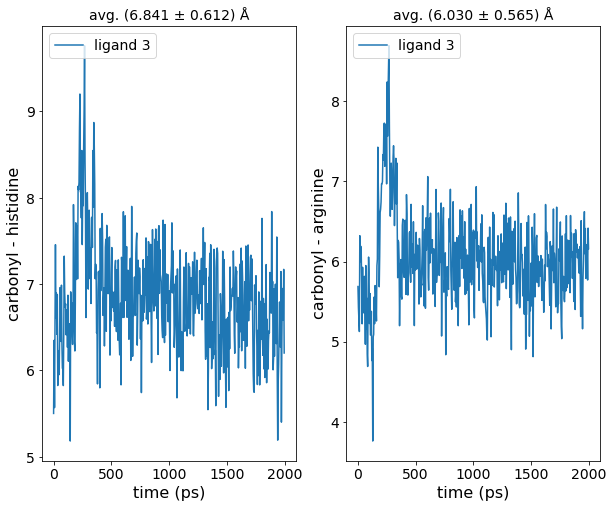

[38.10653305 44.30844116 32.84704971]
[38.49025345 43.86384964 32.59955597]
[38.76493835 44.00257492 32.38613892]
[38.52488327 44.52721024 32.20334625]
[38.6941452  43.92712784 32.34567642]
[38.16590118 43.83354187 32.30735016]
[38.31455231 44.09914398 32.75505066]
[37.9144516  44.3314743  32.26747513]
[38.34446335 44.54169846 32.27587509]
[38.58798599 44.75881958 32.39235306]
[38.00669479 44.65666962 32.5010376 ]
[38.04253006 44.80916595 32.27111816]
[38.25214767 44.63496017 32.31658173]
[38.45510864 45.13978958 32.25090027]
[38.45632172 44.66309738 32.21329117]
[38.88543701 44.51220703 32.2420578 ]
[38.71376801 44.24670029 32.28303146]
[38.55441284 44.52922058 32.1565094 ]
[38.6373024  44.64861679 31.88458824]
[38.73864746 45.03271103 31.75534248]
[38.58837509 44.58397675 31.80395317]
[38.48093796 44.2702446  31.73643303]
[38.49536896 44.41704559 31.40814018]
[38.48441315 44.44298172 31.41097832]
[38.80859375 44.4723587  31.30753708]
[38.86316299 44.65665817 31.50051117]
[39.14036179

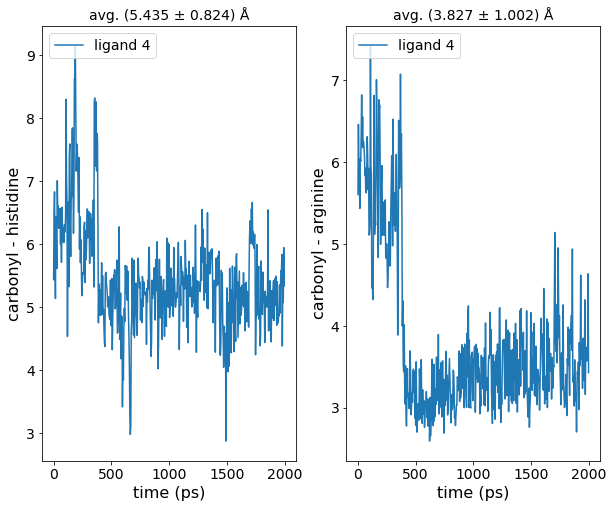

[38.63777924 44.52512741 32.01067352]
[38.30364609 44.21871567 32.02019119]
[37.93100357 44.27887726 32.29674911]
[38.73945618 44.31774902 32.8297348 ]
[38.57193756 44.47723007 32.86668015]
[38.82718277 44.59796524 32.92110443]
[38.77632141 45.15392685 32.63311768]
[38.27397156 44.90578461 32.78814316]
[38.63835907 44.61906433 32.69817352]
[38.65610123 44.65179825 32.67296982]
[38.47628784 44.46494675 32.41371155]
[38.72157288 44.35961533 32.29434967]
[38.9805336  44.79842377 32.84476852]
[38.85611725 44.86517334 32.92754364]
[38.41335297 44.25840759 32.69654846]
[38.56628036 44.69228745 32.75385284]
[38.39504242 44.76680374 32.60566711]
[38.16952133 44.665802   32.4977951 ]
[38.43048859 44.92309189 33.3093071 ]
[37.88859177 44.59620285 32.74207687]
[38.26050568 44.67082596 33.04849625]
[38.35369492 44.87016678 32.72457504]
[38.55020905 44.92617798 33.20057678]
[38.35122681 44.6745224  33.04850769]
[38.43012238 44.72935867 33.17693329]
[38.50372314 44.85486221 32.83944321]
[38.61271286

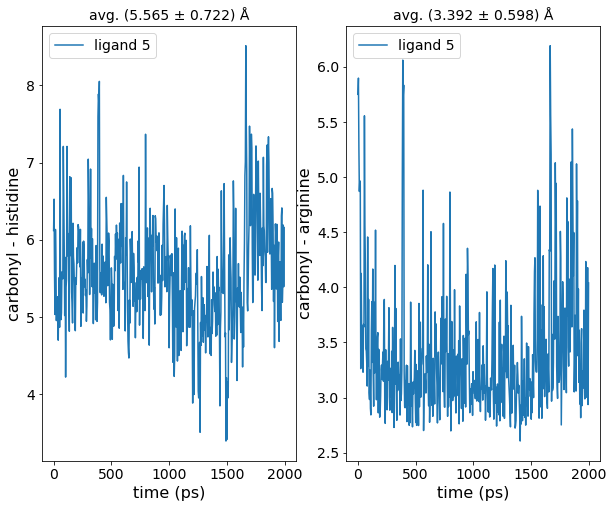

[38.11660767 44.81035995 32.62308121]
[38.02186203 44.54794312 32.2409668 ]
[38.73151779 45.01003647 32.5295372 ]
[38.34326172 44.99707794 32.69734955]
[38.06792831 44.77803802 32.86301041]
[38.25759125 44.46522903 33.0283699 ]
[38.05715561 44.89224243 32.84130096]
[38.17155838 44.54519653 32.43480682]
[38.27886963 44.38573074 32.74040222]
[38.67799377 44.68781281 32.8943367 ]
[38.53891754 44.49526215 32.48752594]
[38.4067688  44.57749176 32.3228035 ]
[38.28452301 44.53791428 32.5190773 ]
[37.9729538  44.45867157 32.13939285]
[38.03501892 44.46289063 32.37415695]
[38.24018478 44.26227188 32.50137329]
[38.25624847 44.55475998 32.62442398]
[38.27170181 44.15823746 32.14082336]
[38.17449188 44.59990692 32.15009689]
[38.17314529 44.91849136 31.953125  ]
[38.21697235 44.67380905 32.43280029]
[38.34169006 44.98862076 32.31438065]
[38.10961151 44.4684906  32.65488052]
[37.82987213 44.94735336 32.47476959]
[37.65395355 44.69601059 32.5853157 ]
[37.69043732 44.41307068 32.71944046]
[37.66644287

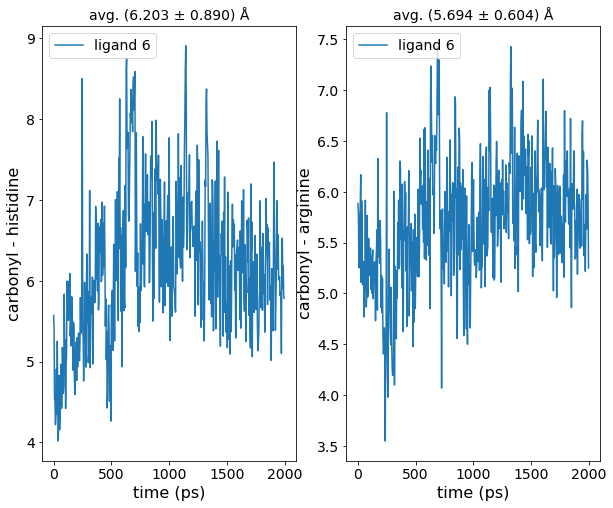

[38.28242874 44.18964767 32.52195358]
[38.50272751 43.86039352 32.9028511 ]
[38.68248367 44.33790207 32.93996429]
[38.31838989 43.59151459 32.3740654 ]
[38.66060638 44.41225052 32.92521667]
[38.38094711 44.24560928 33.16970444]
[37.89024353 44.25137711 32.82296753]
[37.55809784 44.21855545 32.64739609]
[38.07176208 44.74475098 32.79458237]
[38.03164673 44.19610214 32.66191101]
[38.37725449 44.80579376 32.96927643]
[37.65819931 44.45916367 32.11468506]
[37.64273453 44.64954376 32.43091965]
[37.55778122 44.53388214 32.5306282 ]
[38.32977676 44.71546936 32.66269302]
[38.08808899 44.92297363 32.29544449]
[37.98353958 44.42255783 32.77830505]
[37.91470337 44.81353378 32.6149826 ]
[37.37882233 43.86692047 31.99908829]
[37.44960403 44.09564972 31.98713303]
[37.46258926 43.97079468 32.49277878]
[37.62493134 44.52011871 32.29900742]
[37.7549057  43.97306061 31.98767853]
[37.71706772 44.21660614 32.16044235]
[37.60194778 43.99689102 32.70922089]
[37.58182526 43.63118744 31.88497543]
[37.37064743

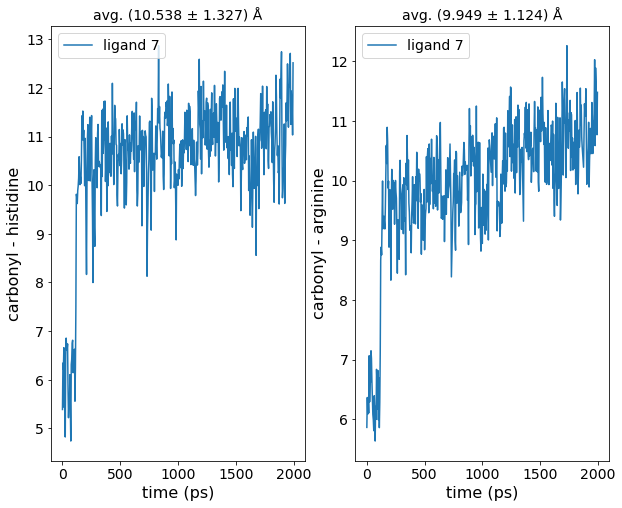

[38.23958588 44.37528229 32.82695389]
[38.63613129 44.14009857 32.35612869]
[38.72291183 44.25649643 32.46405411]
[38.67576599 44.35793304 32.4745903 ]
[38.105896   43.98323441 32.18600845]
[38.52348709 44.37881088 32.51735306]
[38.31044769 44.19118881 32.07754898]
[38.18851471 44.18822098 32.29184341]
[38.35126114 44.42270279 31.86678886]
[37.6699295  44.06166458 32.25859451]
[37.79666901 43.91106415 31.62397385]
[37.60474777 43.59725571 31.6169281 ]
[37.71237946 43.88167953 31.8067112 ]
[37.97182846 44.64136887 31.82773018]
[38.2696991  44.25470734 32.17097473]
[37.97304916 44.36829758 32.09306335]
[37.81612396 44.36882401 31.67553329]
[38.1296196  44.15575027 32.18507385]
[37.94284439 44.49337387 32.0658493 ]
[38.14195251 44.79762268 32.12585831]
[38.31920624 44.46980286 32.27719498]
[38.30513763 44.63240814 32.06351852]
[38.00562286 44.02748489 31.99250031]
[37.9924202  44.68843842 32.18947601]
[38.1363678  44.56589127 31.74080467]
[38.65962982 44.52436447 32.18562317]
[38.44850159

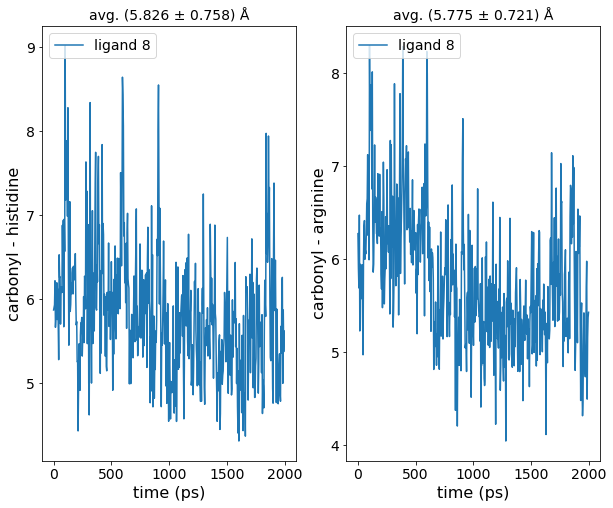

[38.71849823 44.61507034 32.72276688]
[38.7385025  44.11965942 32.78580856]
[38.96128464 44.20425034 32.5659523 ]
[38.73998642 44.45254898 32.96900177]
[39.04457855 44.58771896 32.72814178]
[39.06130981 44.53426361 32.78544235]
[38.647892   44.48762131 32.75367737]
[38.55722427 44.57686234 32.51648712]
[38.74397278 44.38079453 32.67520905]
[39.06824112 44.75862503 33.11601257]
[38.75465012 44.62179184 32.66221619]
[38.82466888 44.2477684  32.56009293]
[38.38477707 44.46620941 32.26257706]
[38.23038864 44.22394943 32.39199829]
[38.20950317 44.56845856 32.14034271]
[38.8383522  44.8431282  32.47822952]
[38.42556    44.41592407 32.24552536]
[38.67395782 44.85515594 32.39493942]
[38.31988144 44.16712952 32.42393494]
[38.63265228 43.71204758 32.58626938]
[38.46243286 43.37301254 32.36741638]
[38.71573639 43.33850098 32.28282166]
[38.72107315 43.85297012 32.07217789]
[38.66075134 43.79576492 31.9801693 ]
[38.69365692 43.98090744 32.05259705]
[38.54395294 43.78162766 31.96536827]
[38.52805328

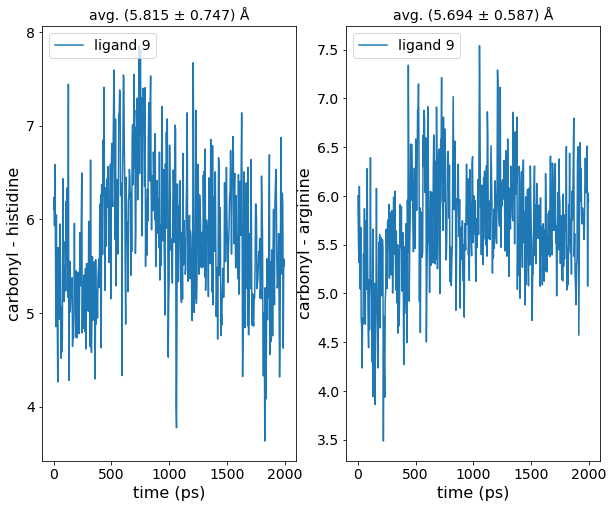

[36.72981644 45.89209747 34.055439  ]
[36.79209137 45.59409332 34.20243835]
[37.48155975 45.69739914 34.27119827]
[37.34332275 45.84962463 34.10567856]
[37.81631088 45.90152359 34.63557816]
[37.34786224 45.42273712 33.98099136]
[37.56238556 45.62843323 34.45549393]
[37.1746788  45.37707901 34.10783386]
[37.33296204 45.41754532 34.15930939]
[36.44252014 44.96510315 33.95546722]
[36.96855545 45.20071411 34.43917847]
[36.87442398 44.97584152 34.50428391]
[36.42111588 45.37637329 34.15377426]
[36.88202667 45.81604767 34.32942581]
[36.82405853 45.35380173 33.98551559]
[37.07868576 44.94820404 34.01304245]
[37.47916794 45.36826706 34.20271301]
[37.1607933  45.45088196 34.25385284]
[37.13550949 45.64350891 34.16002274]
[36.84082413 45.42955399 34.00042725]
[37.13645935 45.3433609  34.05972672]
[37.34952164 45.64836502 34.19252014]
[37.07263184 45.35368347 33.86433029]
[36.9491806  44.88055038 33.8499527 ]
[37.01573181 45.51437759 33.79217148]
[36.90031433 45.28201675 33.71395493]
[37.20461273

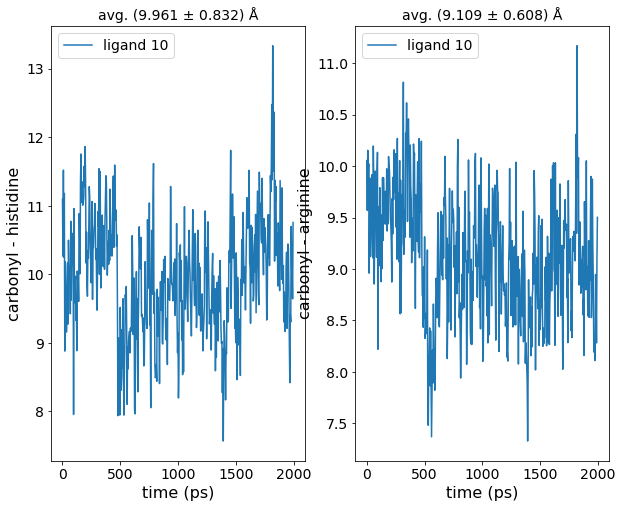

[39.06058121 44.71717453 32.72066879]
[38.60172272 44.12263489 32.57995605]
[38.94968796 44.11251068 32.94297791]
[38.58597183 43.7323494  32.77036285]
[38.77271271 44.13852692 32.66000366]
[38.56048965 44.08334732 32.87442398]
[38.77944565 44.00257874 33.07658386]
[38.73856354 44.27031708 32.71384811]
[38.25499725 44.86124039 33.00259018]
[38.66545486 44.8505249  32.91759872]
[37.90802002 44.04649353 32.54586411]
[38.21757507 44.0967598  32.67668915]
[37.67588806 43.65478897 32.46877289]
[37.83005905 43.83873367 32.24617386]
[37.76715851 44.00657654 32.32456207]
[37.6594429  44.03218842 32.11242676]
[37.71416473 43.86804962 32.24285126]
[37.74707413 44.01015091 31.83899498]
[37.73510742 43.51318359 32.38611984]
[38.02376938 44.00745773 32.08385086]
[37.72043991 44.03286743 32.03673935]
[37.54964447 43.83859634 31.78040314]
[37.97619247 43.47782898 32.09866333]
[37.87454605 43.62799072 32.37606049]
[37.8066864  43.75293732 32.05864334]
[38.12151337 43.50721359 31.97554398]
[38.3397789 

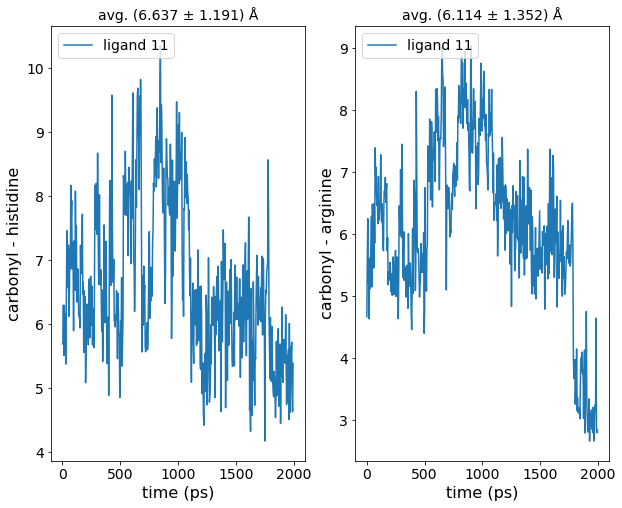

[38.79410934 44.82657623 32.66483307]
[38.31586075 44.07709122 32.32964706]
[38.58467484 44.59533691 32.39145279]
[38.81802368 44.18214035 32.77164078]
[38.40245819 44.37654114 33.19345474]
[38.30742645 44.12499237 32.36085892]
[39.06801605 44.35023117 33.0773735 ]
[38.89659119 44.01322174 33.12229156]
[38.61448669 44.41581726 32.55714035]
[38.54026031 44.80781937 32.75154877]
[38.4462471  44.19766998 32.77355576]
[38.14536667 43.74615479 32.49089432]
[38.50868988 44.30720901 32.70490646]
[38.34655762 44.02864075 32.36353302]
[38.33778    43.69298553 32.50242615]
[38.6285553  43.99316025 32.94379425]
[38.60270309 44.05569839 32.75835037]
[38.42028427 43.48689651 32.85118103]
[38.68028641 43.59962463 32.8262291 ]
[38.88964462 43.67976761 32.4167366 ]
[38.69498062 44.0210762  32.88645935]
[38.76221848 43.56137466 32.68785095]
[38.84872818 43.85145187 32.98656464]
[39.07332993 44.07938385 33.088974  ]
[38.87770844 44.12070084 33.04217911]
[38.77077866 43.93365479 33.11732101]
[38.78390121

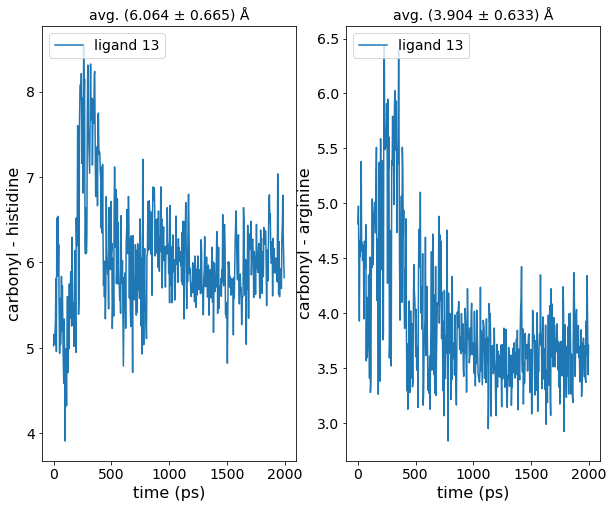

[38.1965332  44.57809448 32.84937286]
[38.42723846 44.37259293 32.61912537]
[38.85929489 44.31116867 32.96005249]
[38.83920288 44.49793243 32.74139786]
[38.63929749 44.86564255 32.68674088]
[38.42692947 44.80318451 31.9109211 ]
[38.64479065 44.6667099  32.33901215]
[38.52070236 44.31750488 32.61919785]
[38.5575943  44.75011063 33.02791595]
[38.42777252 44.6216507  32.35757828]
[38.48561859 44.25184631 32.18543625]
[38.21333313 44.0965538  32.45741272]
[38.17639923 44.94181824 31.89100266]
[38.5451355  44.84256363 32.35631943]
[38.25804138 44.93912506 32.02867126]
[38.47981644 44.87808609 32.35874939]
[38.42292023 44.67020035 31.88187981]
[38.73167801 44.63523483 32.34833145]
[38.4115181  43.93737793 31.96895599]
[38.79772568 44.1289711  32.32250595]
[38.71208954 44.28416824 32.75130844]
[38.03123856 43.44905853 32.19999313]
[38.50537872 44.28843307 32.13725281]
[38.58848953 43.78168488 32.6462822 ]
[38.52864075 43.79240036 32.67593384]
[38.90016174 43.9305191  32.53010941]
[38.60020447

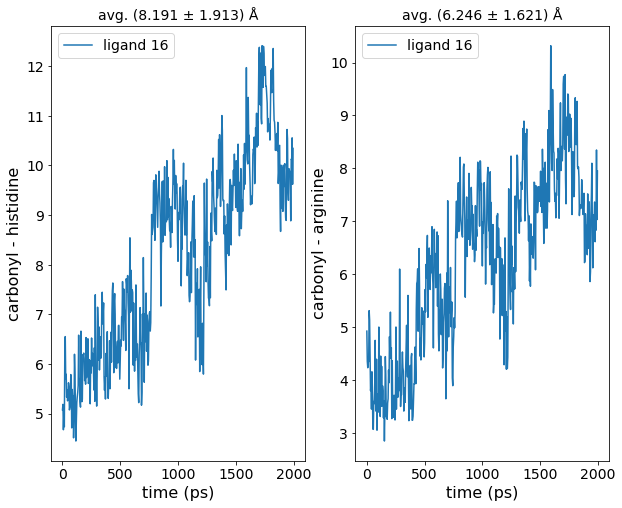

In [6]:
for i in range(len(trajectories)):
    histidine_distances = []
    arginine_distances = []
    for frame in trajectories[i]:
        time = bonding_data[i][0]
        arginine = bonding_data[i][1].select_atoms("resid 197")
        histidine = bonding_data[i][1].select_atoms("resid 250")
        ligand = bonding_data[i][2]
        arginine_nitrogen = arginine.select_atoms("name NH2").center_of_mass()
        histidine_nitrogen = histidine.select_atoms("name NE2").center_of_mass()
        carbonyl_oxygen = ligand.select_atoms("name O1").center_of_mass()
        print(arginine_nitrogen)
        histidine_distance = mda.analysis.distances.distance_array(carbonyl_oxygen, histidine_nitrogen)
        arginine_distance = mda.analysis.distances.distance_array(carbonyl_oxygen, arginine_nitrogen)

        histidine_distances.append((frame.time, histidine_distance[0][0]))
        arginine_distances.append((frame.time, arginine_distance[0][0]))
    histidine_distances = np.asarray(histidine_distances)
    arginine_distances = np.asarray(arginine_distances)

    mean_his_distance = np.mean(histidine_distances[:,1])
    std_his_distance = np.std(histidine_distances[:,1])
    mean_arg_distance = np.mean(arginine_distances[:,1])
    std_arg_distance = np.std(arginine_distances[:,1])

    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(10, 8)
    ax[0].plot(histidine_distances[:,0], histidine_distances[:,1], label=f"ligand {ligand_indices[i]}")
    ax[1].plot(arginine_distances[:,0], arginine_distances[:,1], label=f"ligand {ligand_indices[i]}")
    ax[0].set_xlabel("time (ps)")
    ax[0].set_ylabel("carbonyl - histidine")
    ax[1].set_ylabel("carbonyl - arginine")
    ax[1].set_xlabel("time (ps)")

    ax[0].set_title(f"avg. ({mean_his_distance:.3f} \u00B1 {std_his_distance:.3f}) \u212B")
    ax[1].set_title(f"avg. ({mean_arg_distance:.3f} \u00B1 {std_arg_distance:.3f}) \u212B")

    ax[0].legend(loc="upper left")
    ax[1].legend(loc="upper left")
    plt.show()

In [95]:
ligand = bonding_data[-3][2]

In [96]:
nv.show_mdanalysis(ligand)

NGLWidget(max_frame=499)

In [75]:
nv.show_mdanalysis(arginine)

NGLWidget(max_frame=499)

In [76]:
nv.show_mdanalysis(histidine)

NGLWidget(max_frame=499)